## Assignment Title: Fake News Detection using NLP
### Problem Statement

In the current digital era, misinformation and fake news spread rapidly on social media
and online platforms. Identifying and filtering fake news is crucial for maintaining
credible information sources.

As a data scientist working for X Social Media Analytics, your task is to develop an
NLP-based classification model to detect whether a given news article is fake or true.
You'll work with real-world datasets collected from reliable and unreliable news sources.

In [3]:
import pandas as pd
import numpy as np

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score , classification_report #for accuracy check

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()#enable progress_apply() in pandas

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rajsh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [4]:
#!pip install nltk


## Data Loading and Labeling

In [6]:
true_df = pd.read_csv(r"C:\Users\rajsh\INNOMATICS\Machine Learning Module 7\ML Phase 1\True Fake News Text Preprocessing Project\True.csv")
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
#Add a new column label: 1 for real news (True.csv)
true_df["label"] = 1 

In [8]:
true_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [9]:
fake_df = pd.read_csv(r"C:\Users\rajsh\INNOMATICS\Machine Learning Module 7\ML Phase 1\True Fake News Text Preprocessing Project\Fake.csv")
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [10]:
fake_df["label"] = 0

In [11]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Understand the data : 

In [12]:
# Combine both datasets (true_df and fake_df) into one and shuffle.
news_df = pd.concat([true_df , fake_df])

In [13]:
#Drop = True: removes the old index instead of adding it as a column.
#Inplace = True: applies the change directly to your news_df
news_df.reset_index(drop =True , inplace =True)

In [14]:
# Data does not have any null values
news_df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [15]:
news_df.duplicated().sum()

np.int64(209)

In [16]:
news_df.drop_duplicates(inplace = True)

In [17]:
news_df.shape

(44689, 5)

## Data Cleaning and Preprocessing

In [18]:

# Creating a function for data preprocessing

#(Convert into lowercase , Remove Punctuation , Numbers, HTML tags, Extra WHITESPACE)
#(Tokenize text , Remove Stopwords)
#(Apply stemming or lemmatization)
# So to complete the above tasks, we need to create a single function

def preprocess_data(data , flag):
    sentence = re.sub("[^a-zA-Z]" ," ",data) # removing special characters digits
    
    sentence = sentence.lower() # Lowercase text
    
    tokens_words = sentence.split() #token into words

    stop_words = set(stopwords.words("english"))

    clean_tokens =[token for token in tokens_words if token not in stop_words ] #remove stopwords

    if flag == "stem":
        clean_tokens = [stemmer.stem(word) for word in clean_tokens ]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]

    preprocessed_text = " ".join(clean_tokens)
    token_count = len(clean_tokens)

    return pd.Series([preprocessed_text , token_count])

# lemmatization : 

In [22]:
import nltk

# download WordNet and the multilingual wordnet mappings (recommended)
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rajsh\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rajsh\AppData\Roaming\nltk_data...


True

In [23]:
tran_lemma = news_df["text"].progress_apply(lambda x: preprocess_data(x , "lemma"))

100%|███████████████████████████████████████████████████████████████████████████| 44689/44689 [01:15<00:00, 592.69it/s]


### lemmatization returns meaningful token words

In [24]:
tran_lemma.columns = ['clean_text_lemma' , 'clean_text_count']

In [25]:
news_data = pd.concat([news_df , tran_lemma], axis =1) #Clean title and merge with content

In [26]:
news_data

,title,text,subject,date,label,clean_text_lemma,clean_text_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuters head conservative republica...,440
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuters transgender people allowed ...,378
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuters special counsel investigati...,262
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuters trump campaign adviser geor...,230
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattle washington reuters president donald tr...,494
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,st century wire say wire reported earlier week...,319
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,st century wire say familiar theme whenever di...,168
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen st century wireremember oba...,2374
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,st century wire say al jazeera america go hist...,275


# EDA on data

<Axes: xlabel='label', ylabel='count'>

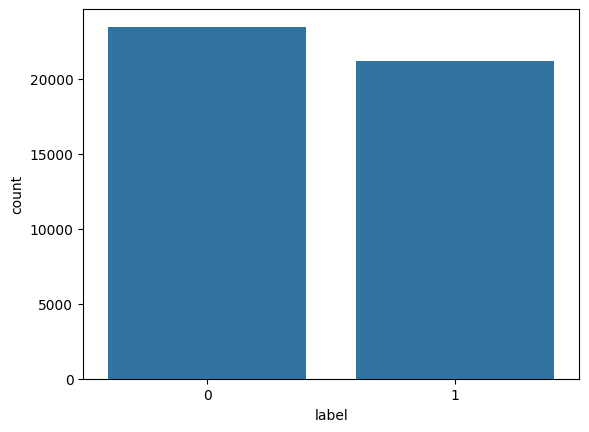

In [27]:
# Plot label distribution (Fake vs True)
sns.countplot(x = "label" ,data = news_df)

### Observation: In data, most of the news is fake. Above: 25000

<Axes: xlabel='subject', ylabel='count'>

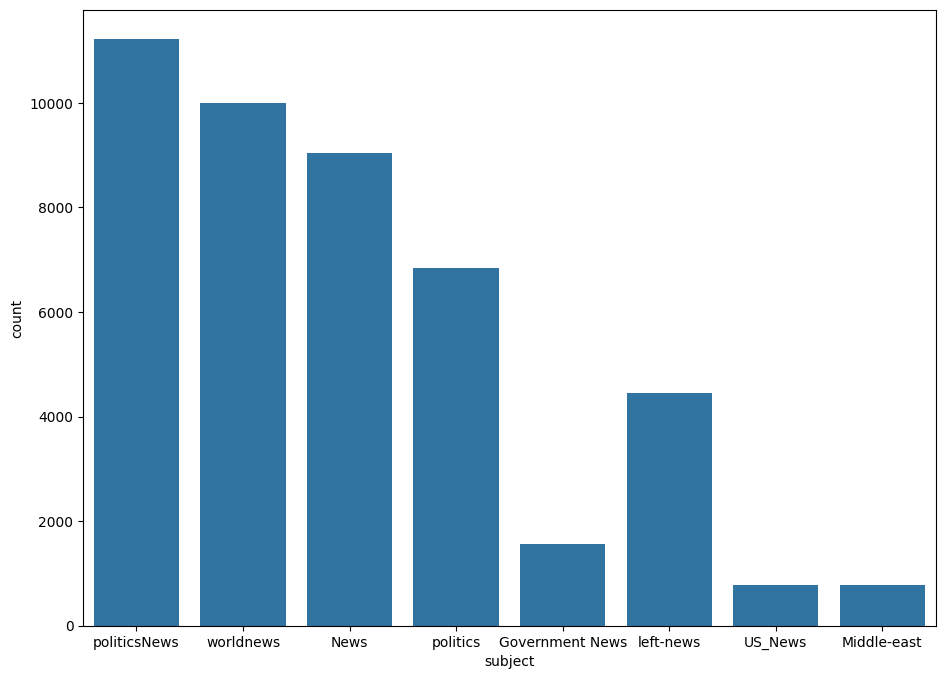

In [28]:
#Word count distribution per class
plt.figure(figsize =(11,8))
sns.countplot(x ="subject" ,data = news_data)

### Observation : in data most of news is about politics world news

In [29]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44897
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             44689 non-null  object
 1   text              44689 non-null  object
 2   subject           44689 non-null  object
 3   date              44689 non-null  object
 4   label             44689 non-null  int64 
 5   clean_text_lemma  44689 non-null  object
 6   clean_text_count  44689 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.7+ MB


## Visualization the Distribution of the Most Frequent Word

In [30]:
from collections import Counter

all_words = " ".join(news_data["clean_text_lemma"].values).split()
word_counts = Counter(all_words)

common_word = word_counts #most_common(20)
common_word = dict(common_word)
#now convert it to DataFrame
#common_word_df = pd.DataFrame(common_word , columns =["word" ,"count"])

In [31]:
common_word

{'washington': 18639,
 'reuters': 29132,
 'head': 6161,
 'conservative': 9716,
 'republican': 39622,
 'faction': 577,
 'u': 71381,
 'congress': 10162,
 'voted': 2915,
 'month': 14202,
 'huge': 1879,
 'expansion': 662,
 'national': 15846,
 'debt': 2602,
 'pay': 5162,
 'tax': 13422,
 'cut': 5181,
 'called': 13150,
 'fiscal': 1670,
 'sunday': 6124,
 'urged': 2072,
 'budget': 4649,
 'restraint': 174,
 'keeping': 1226,
 'sharp': 567,
 'pivot': 163,
 'way': 14419,
 'among': 6245,
 'representative': 6370,
 'mark': 2925,
 'meadow': 170,
 'speaking': 3704,
 'cbs': 1162,
 'face': 6158,
 'nation': 11183,
 'drew': 1239,
 'hard': 4434,
 'line': 5113,
 'federal': 11817,
 'spending': 3267,
 'lawmaker': 5932,
 'bracing': 39,
 'battle': 1955,
 'january': 5351,
 'return': 4042,
 'holiday': 776,
 'wednesday': 10005,
 'begin': 2134,
 'trying': 5671,
 'pas': 2644,
 'fight': 4609,
 'likely': 6284,
 'linked': 1270,
 'issue': 11084,
 'immigration': 6339,
 'policy': 12974,
 'even': 17967,
 'november': 4717,
 '

In [34]:
!pip install wordcloud



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


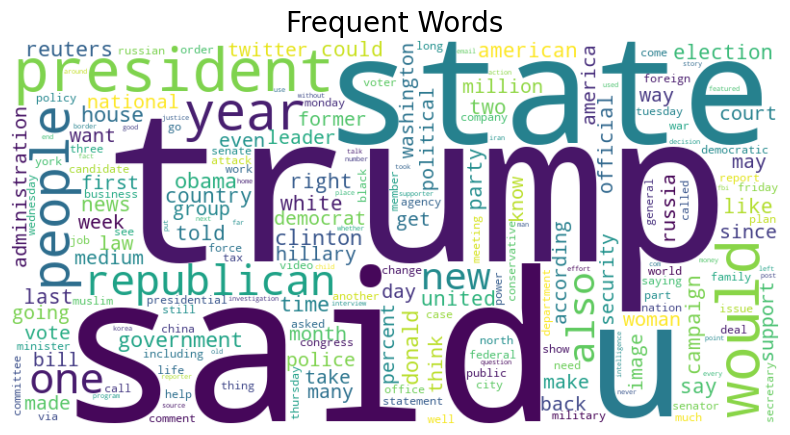

In [35]:
#Most frequent words in fake vs real news
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words', fontsize=20)
plt.show()

### Observation: the most common words in clean text are Said, Trump, U, People, year, state, would.

In [36]:
from collections import Counter

all_words = " ".join(news_data["text"].values).split()
word_counts_text = Counter(all_words)

common_word_text = word_counts_text #most_common(20)
common_word_text = dict(common_word_text)

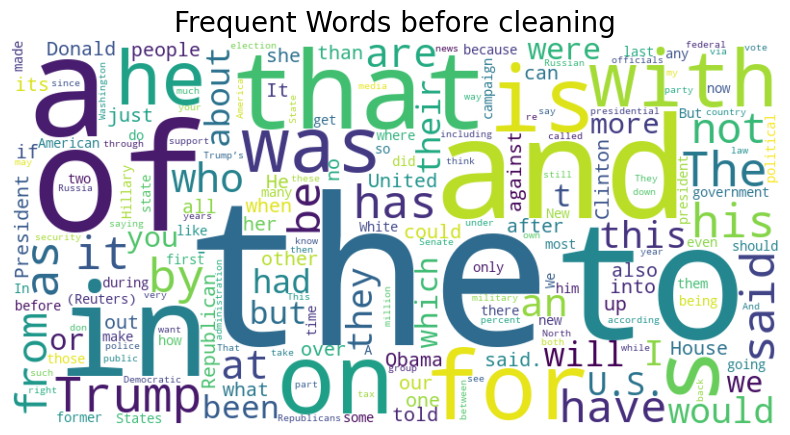

In [37]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words before cleaning', fontsize=20)
plt.show()

### Observation: the, to, that, and, of, was, is, this are nothing but stopwords

## Model Building:

## Data prepearation - Split the Data into train and test set 

In [38]:
news_data

,title,text,subject,date,label,clean_text_lemma,clean_text_count
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuters head conservative republica...,440
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuters transgender people allowed ...,378
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuters special counsel investigati...,262
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuters trump campaign adviser geor...,230
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattle washington reuters president donald tr...,494
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,st century wire say wire reported earlier week...,319
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,st century wire say familiar theme whenever di...,168
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen st century wireremember oba...,2374
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,st century wire say al jazeera america go hist...,275


In [39]:
y= news_data["label"]
x = news_data[["clean_text_lemma"]]

In [40]:
from sklearn.model_selection import train_test_split
x_train ,x_test ,y_train, y_test = train_test_split(x , y , test_size =0.2)

In [41]:
x_train.head(10)

,clean_text_lemma
39593,msnbc brian williams spoke truth tuesday night...
4089,berlin reuters ivanka trump booed berlin tuesd...
10993,washington reuters u republican presidential c...
13658,geneva reuters syrian government accepted russ...
25574,one donald trump latest conspiracy theory spre...
42948,baby bag freezer yes reality abortion industry...
34182,longtime republican financial backer attended ...
6648,west palm beach fla reuters president elect do...
37638,watch joy behar hilariously attempt tie anti s...
41702,rush limbaugh spot analysis barack obama inten...


## Feature Extraction :

In [42]:
vocab = CountVectorizer()

X_train_bow = vocab.fit_transform(x_train['clean_text_lemma'])

In [43]:
X_train_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 5602002 stored elements and shape (35751, 97603)>

In [44]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 97603
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (35751, 97603)


In [45]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow),"Bytes")
#This line shows how much memory (RAM) the object X_train_bow is taking up in bytes.

<class 'scipy.sparse._csr.csr_matrix'>
48 Bytes


In [46]:
X_test_bow = vocab.transform(x_test['clean_text_lemma'])

# Logistic regression :

In [47]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [48]:
y_test_pred = classifier.predict(X_test_bow)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9951890803311703
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4719
           1       1.00      0.99      0.99      4219

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



# Decision Tree :

In [50]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bow, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [51]:
y_test_pred = classifier.predict(X_test_bow)

In [52]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9959722533005146
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4719
           1       1.00      1.00      1.00      4219

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



# Random Forest :

In [53]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
y_test_pred = classifier.predict(X_test_bow)

In [55]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9922801521593198
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4719
           1       0.99      0.99      0.99      4219

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



### Observation: Random Forest algorithm has highest accuracy

In [56]:
from sklearn.naive_bayes import MultinomialNB 
classifier = MultinomialNB()
classifier.fit(X_train_bow ,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [57]:
y_test_pred = classifier.predict(X_test_bow)

In [58]:
print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9522264488699933
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4719
           1       0.95      0.95      0.95      4219

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938

